- RNN: Recurrent Neural Network
- LSTM: Long Short Term Memory
- ES: Early Stopping
- Multi-Step time series forecasting
- Multivariate (inputs Price and Volume)

In [22]:
# parameters
n_past_total = 1200 #1500 #2000
n_past = 120 #30 #50
prediction_days = 30 #10
activation = 'softsign' #'softsign' #'relu' #'sigmoid'
dropout = 0.0
n_layers = 2 #hidden layers
n_neurons = 10
n_features = 2
patience = 25

In [10]:
import numpy as np
import pandas as pd

import datetime
from datetime import datetime, timezone
import datetime as dt
import requests




from matplotlib import pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
pd.set_option('display.float_format', lambda x: '%.3f' % x) #avoid scientific notation
np.set_printoptions(suppress=True)

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from keras.callbacks import EarlyStopping
import seaborn as sns

# Data 

In [13]:
#Date input from user
print("Please add 1 hour to the `to` input to make sure that you always get data for the end date as well.")

start_date = str(input('Enter a start date in YYYY-MM-DD-H-M (2021-12-27-14-41) format: '))
end_date = str(input('Enter a end date in YYYY-MM-DD-H-M (2021-12-27-14-41) format: '))

Please add 1 hour to the `to` input to make sure that you always get data for the end date as well.
Enter a start date in YYYY-MM-DD-H-M (2021-12-27-14-41) format: 2018-01-01-12-00
Enter a end date in YYYY-MM-DD-H-M (2021-12-27-14-41) format: 2022-01-12-12-00


**Note:** Hourly based data

In [14]:
def get_bitcoin_data_df(start_date, end_date):

    print( "the bitcoin data between {} and {} dates is being obtained".format(start_date,end_date))

    #Converting the entered date data to datetime format
    start_date_timestamp = datetime.strptime(start_date, "%Y-%m-%d-%H-%M")
    end_date_timestamp = datetime.strptime(end_date, "%Y-%m-%d-%H-%M")

    #Converting the entered date information to timestamp
    timestamp1 = start_date_timestamp.replace(tzinfo=timezone.utc).timestamp()
    timestamp2 = end_date_timestamp.replace(tzinfo=timezone.utc).timestamp()
    
    #Getting the needed data from CoinGecko’s public API 
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart/range?vs_currency=eur&from={}&to={}".format(timestamp1,timestamp2)
    req = requests.get(url=url)
    json=req.json()
    
    #Converting json data to dataframe
    df1 = pd.DataFrame(json['prices'],columns=["time","prices"])
    df2 = pd.DataFrame(json['market_caps'],columns=["time","market_caps"])
    df3 = pd.DataFrame(json['total_volumes'],columns=["time","total_volumes"])
    df=df1.merge(df2, how='left', on='time')
    df=df.merge(df3, how='left', on='time')
    
    #Converting timestamp information of time column to datetime format
    timestamp=df["time"].tolist()  
    time=[]
    for i in timestamp: 
        i=int(str(i)[:10])
        date = dt.datetime.utcfromtimestamp(i)
        time.append(date)
    df["time"]=time
    
    #Indexing the time column
    df.set_index('time', inplace=True)
    
    #Selecting data at 00:00 UTC from hourly data, when given a date range of 1 to 90 days
    df=df[(df.index.hour ==0 )]
    
    return df



In [15]:
# Data
df=get_bitcoin_data_df(start_date, end_date)
print('\n', df.head())

print('\n ---------------------\n')

print(df.tail())

the bitcoin data between 2018-01-01-12-00 and 2022-01-12-12-00 dates is being obtained

               prices      market_caps  total_volumes
time                                                
2018-01-02 12700.013 213087638999.247 3423446756.006
2018-01-03 12977.107 217762169745.293 2756619198.288
2018-01-04 13237.233 222155020469.905 3494320371.612
2018-01-05 15243.924 255859922492.807 5217129715.008
2018-01-06 15249.527 255986365943.101 3525578437.183

 ---------------------

              prices      market_caps   total_volumes
time                                                 
2022-01-08 36548.875 693301034511.978 70132506635.610
2022-01-09 36754.381 697907238069.235 20541335916.354
2022-01-10 36877.349 697229426324.866 15871269356.777
2022-01-11 36950.151 699299816842.654 24696439559.759
2022-01-12 37634.150 712281530320.347 20070706205.439


In [16]:
df[['prices','total_volumes']].corr()

,prices,total_volumes
prices,1.000,0.586
total_volumes,0.586,1.000


In [17]:
# checking for nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1472 entries, 2018-01-02 00:00:00 to 2022-01-12 00:00:00
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   prices         1472 non-null   float64
 1   market_caps    1472 non-null   float64
 2   total_volumes  1472 non-null   float64
dtypes: float64(3)
memory usage: 46.0 KB


In [18]:
df.describe()

,prices,market_caps,total_volumes
count,1472.000,1472.000,1472.000
mean,15881.230,293039802422.348,21854289917.551
std,15132.895,286930099296.009,17202549970.406
min,2844.434,49518983278.313,936064716.608
25%,6285.859,109286052221.384,4853600056.843
50%,8412.038,151969437389.541,20049962119.519
75%,26509.559,492918937339.764,31027615172.095
max,58358.420,1103715118055.782,146032480261.851


In [33]:
# use close only and fill NaN with ffil
#n_past_total = 1500 #2000
df = df[['prices','total_volumes']].tail(n_past_total)
df = df.set_index(pd.to_datetime(df.index))
df.fillna(method='ffill',inplace=True)

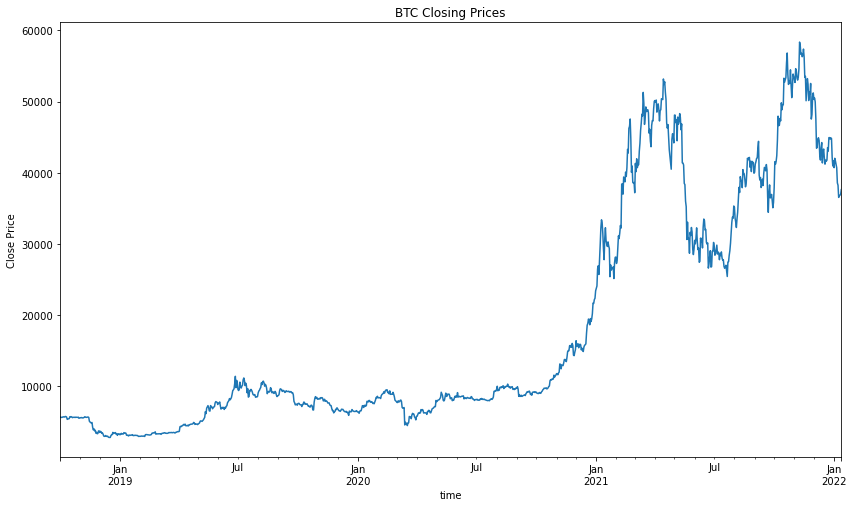

In [34]:
# plotting the Closing Prices
df['prices'].plot(figsize=(14,8))
plt.title('BTC Closing Prices')
plt.ylabel('Close Price')
plt.show()

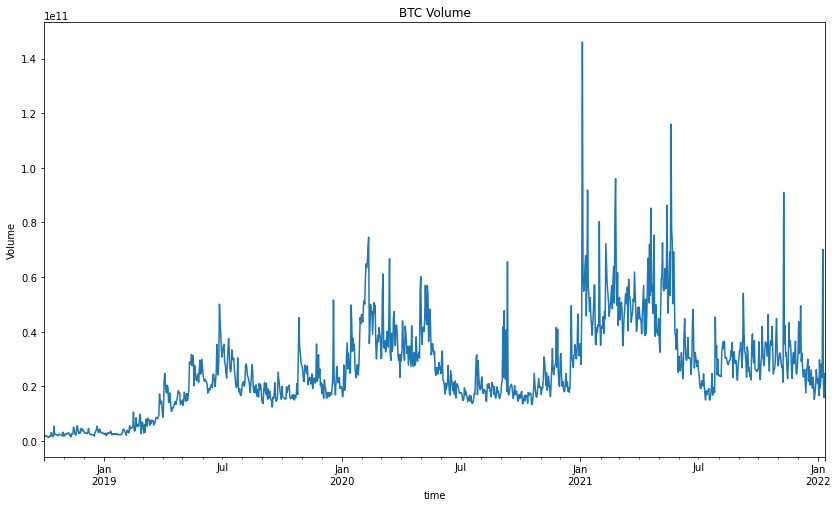

In [35]:
# plotting the Volume
df['total_volumes'].plot(figsize=(14,8))
plt.title('BTC Volume')
plt.ylabel('Volume')
plt.show()

### Data split

In [36]:
# train test split
#prediction_days = 30
df_train = df.head(-prediction_days)
df_test = df.tail(prediction_days)
training_set = df_train.values
test_set = df_test.values
print('training_set.shape = ', training_set.shape)
print('test_set.shape = ', test_set.shape)

training_set.shape =  (1170, 2)
test_set.shape =  (30, 2)


### Data Normalization

In [37]:
# scale
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
print('training_set_scaled.shape', training_set_scaled.shape)
training_set_scaled

training_set_scaled.shape (1170, 2)


array([[0.0516088 , 0.00258714],
       [0.05142726, 0.00252314],
       [0.05049822, 0.00339824],
       ...,
       [0.7016014 , 0.17194721],
       [0.73256033, 0.14149927],
       [0.74592694, 0.11259201]])

### data for future prediction

In [38]:
# creating a data structure with 30 timesteps and 1 output
X_train = []
y_train = []
 
#n_past_total = 1200 
#n_past = 120 
#prediction_days = 30 

#n_future = prediction_days # Number of days you want to predict into the future
#n_past =   # Number of past days you want to use to predict the future

for i in range(n_past, len(training_set_scaled) - prediction_days + 1):
    X_train.append(training_set_scaled[i-n_past:i, :])
    y_train.append(training_set_scaled[i:i+prediction_days, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [39]:
X_train.shape, y_train.shape

((1021, 120, 2), (1021, 30))

In [40]:
range(n_past, len(training_set_scaled) - prediction_days + 1)

range(120, 1141)

In [41]:
range(n_past, len(training_set_scaled)-7)

range(120, 1163)

In [42]:
for i in range(n_past, len(training_set_scaled) - prediction_days + 1):
    print('i={}, [{}, {})'.format(i, i-n_past, i))

i=120, [0, 120)
i=121, [1, 121)
i=122, [2, 122)
i=123, [3, 123)
i=124, [4, 124)
i=125, [5, 125)
i=126, [6, 126)
i=127, [7, 127)
i=128, [8, 128)
i=129, [9, 129)
i=130, [10, 130)
i=131, [11, 131)
i=132, [12, 132)
i=133, [13, 133)
i=134, [14, 134)
i=135, [15, 135)
i=136, [16, 136)
i=137, [17, 137)
i=138, [18, 138)
i=139, [19, 139)
i=140, [20, 140)
i=141, [21, 141)
i=142, [22, 142)
i=143, [23, 143)
i=144, [24, 144)
i=145, [25, 145)
i=146, [26, 146)
i=147, [27, 147)
i=148, [28, 148)
i=149, [29, 149)
i=150, [30, 150)
i=151, [31, 151)
i=152, [32, 152)
i=153, [33, 153)
i=154, [34, 154)
i=155, [35, 155)
i=156, [36, 156)
i=157, [37, 157)
i=158, [38, 158)
i=159, [39, 159)
i=160, [40, 160)
i=161, [41, 161)
i=162, [42, 162)
i=163, [43, 163)
i=164, [44, 164)
i=165, [45, 165)
i=166, [46, 166)
i=167, [47, 167)
i=168, [48, 168)
i=169, [49, 169)
i=170, [50, 170)
i=171, [51, 171)
i=172, [52, 172)
i=173, [53, 173)
i=174, [54, 174)
i=175, [55, 175)
i=176, [56, 176)
i=177, [57, 177)
i=178, [58, 178)
i=179, 

In [43]:
for i in range(n_past, len(training_set_scaled) - prediction_days + 1):
    print('i={}, [{}, {})'.format(i, i, i+prediction_days)) #  i,'-', i, '-', i+n_future)

i=120, [120, 150)
i=121, [121, 151)
i=122, [122, 152)
i=123, [123, 153)
i=124, [124, 154)
i=125, [125, 155)
i=126, [126, 156)
i=127, [127, 157)
i=128, [128, 158)
i=129, [129, 159)
i=130, [130, 160)
i=131, [131, 161)
i=132, [132, 162)
i=133, [133, 163)
i=134, [134, 164)
i=135, [135, 165)
i=136, [136, 166)
i=137, [137, 167)
i=138, [138, 168)
i=139, [139, 169)
i=140, [140, 170)
i=141, [141, 171)
i=142, [142, 172)
i=143, [143, 173)
i=144, [144, 174)
i=145, [145, 175)
i=146, [146, 176)
i=147, [147, 177)
i=148, [148, 178)
i=149, [149, 179)
i=150, [150, 180)
i=151, [151, 181)
i=152, [152, 182)
i=153, [153, 183)
i=154, [154, 184)
i=155, [155, 185)
i=156, [156, 186)
i=157, [157, 187)
i=158, [158, 188)
i=159, [159, 189)
i=160, [160, 190)
i=161, [161, 191)
i=162, [162, 192)
i=163, [163, 193)
i=164, [164, 194)
i=165, [165, 195)
i=166, [166, 196)
i=167, [167, 197)
i=168, [168, 198)
i=169, [169, 199)
i=170, [170, 200)
i=171, [171, 201)
i=172, [172, 202)
i=173, [173, 203)
i=174, [174, 204)
i=175, [17

In [44]:
# reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], n_features))
X_train.shape

(1021, 120, 2)

## LSTM Model

In [45]:
# building the RNN

# Initialising the RNN
regressor = Sequential()

regressor.add(LSTM(units=n_past, return_sequences=True, activation=activation, input_shape=(X_train.shape[1], n_features))) 
#regressor.add(LSTM(units=neurons, return_sequences=True, activation=activation, input_shape=(X_train.shape[1], 1))) 
#regressor.add(Dropout(dropout))

# Hidden layers
for _ in range(n_layers):
    regressor.add(LSTM(units=n_neurons, return_sequences=True, activation=activation))
    regressor.add(Dropout(dropout))

regressor.add(LSTM(units=n_neurons, return_sequences=False, activation=activation))
#regressor.add(Dropout(dropout))

# Adding the output layer
regressor.add(Dense(units=prediction_days))

# Compiling the RNN
regressor.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
#try also with RMSprop

# Model summary
regressor.summary()

2022-01-13 13:06:32.750437: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 120)          59040     
_________________________________________________________________
lstm_1 (LSTM)                (None, 120, 10)           5240      
_________________________________________________________________
dropout (Dropout)            (None, 120, 10)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 120, 10)           840       
_________________________________________________________________
dropout_1 (Dropout)          (None, 120, 10)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 10)                840       
_________________________________________________________________
dense (Dense)                (None, 30)                3

In [46]:
# including early stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=patience)
#early_stop = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=25)

In [23]:
'''
# validation_data
X_val = df['Close'][-n_past-prediction_days:-prediction_days].values.reshape(-1,1)
X_val = sc.transform(X_val)
X_val = X_val.reshape(-1,n_past,n_features)

# getting the true values
y_val = df['Close'][-prediction_days:].values
y_val = sc.transform(y_val.reshape(-1,1))
y_val = y_val.reshape(-1, 10, 1)
X_val.shape, y_val.shape
'''

"\n# validation_data\nX_val = df['Close'][-n_past-prediction_days:-prediction_days].values.reshape(-1,1)\nX_val = sc.transform(X_val)\nX_val = X_val.reshape(-1,n_past,n_features)\n\n# getting the true values\ny_val = df['Close'][-prediction_days:].values\ny_val = sc.transform(y_val.reshape(-1,1))\ny_val = y_val.reshape(-1, 10, 1)\nX_val.shape, y_val.shape\n"

In [47]:
# Fitting the RNN to the Training set
res = regressor.fit(X_train, y_train
                    , batch_size=32
                    , epochs=500
                    #, validation_data=(X_val,y_val)
                    , validation_split=0.1
                    , callbacks=[early_stop]
                   ) 
# 100/32 / 250 , validation_split=0.1)
# the smaller the btach, the less overfitting, normally a number poewr of 2, 32,64,128, etc

Epoch 1/500
29/29 [==============================] - 6s 116ms/step - loss: 0.0937 - accuracy: 0.0196 - val_loss: 0.4754 - val_accuracy: 0.0291
Epoch 2/500
29/29 [==============================] - 3s 107ms/step - loss: 0.0685 - accuracy: 0.0283 - val_loss: 0.3675 - val_accuracy: 0.0583
Epoch 3/500
29/29 [==============================] - 3s 106ms/step - loss: 0.0594 - accuracy: 0.0327 - val_loss: 0.3217 - val_accuracy: 0.0291
Epoch 4/500
29/29 [==============================] - 3s 104ms/step - loss: 0.0573 - accuracy: 0.0359 - val_loss: 0.3311 - val_accuracy: 0.0485
Epoch 5/500
29/29 [==============================] - 3s 106ms/step - loss: 0.0509 - accuracy: 0.0784 - val_loss: 0.3049 - val_accuracy: 0.0485
Epoch 6/500
29/29 [==============================] - 3s 106ms/step - loss: 0.0211 - accuracy: 0.0773 - val_loss: 0.0388 - val_accuracy: 0.0388
Epoch 7/500
29/29 [==============================] - 3s 105ms/step - loss: 0.0068 - accuracy: 0.0381 - val_loss: 0.0397 - val_accuracy: 0.0291

Epoch 58/500
29/29 [==============================] - 3s 110ms/step - loss: 0.0053 - accuracy: 0.0664 - val_loss: 0.0379 - val_accuracy: 0.0583
Epoch 59/500
29/29 [==============================] - 3s 121ms/step - loss: 0.0053 - accuracy: 0.0817 - val_loss: 0.0329 - val_accuracy: 0.0388
Epoch 60/500
29/29 [==============================] - 3s 115ms/step - loss: 0.0053 - accuracy: 0.0752 - val_loss: 0.0338 - val_accuracy: 0.0971
Epoch 61/500
29/29 [==============================] - 3s 105ms/step - loss: 0.0054 - accuracy: 0.0839 - val_loss: 0.0336 - val_accuracy: 0.0388
Epoch 62/500
29/29 [==============================] - 3s 105ms/step - loss: 0.0054 - accuracy: 0.0697 - val_loss: 0.0391 - val_accuracy: 0.0583
Epoch 63/500
29/29 [==============================] - 3s 107ms/step - loss: 0.0053 - accuracy: 0.0795 - val_loss: 0.0399 - val_accuracy: 0.0583
Epoch 64/500
29/29 [==============================] - 4s 131ms/step - loss: 0.0053 - accuracy: 0.0697 - val_loss: 0.0390 - val_accuracy:

In [48]:
#regressor.save('regressor.h5')

In [49]:
list(res.history)

['loss', 'accuracy', 'val_loss', 'val_accuracy']

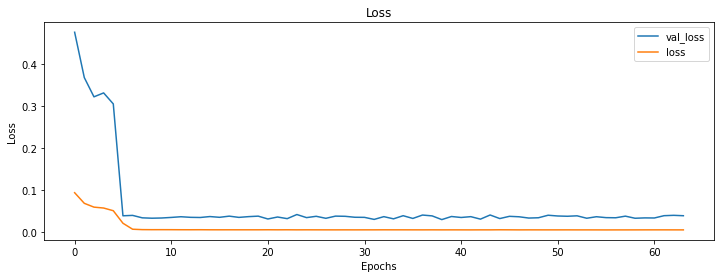

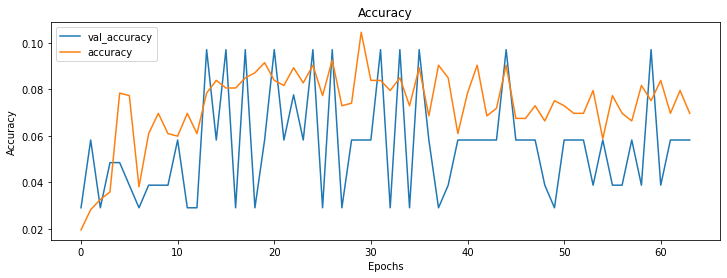

In [50]:
# Plotting Accuracy and Loss

results = res

history = results.history
plt.figure(figsize=(12,4))
plt.plot(history['val_loss'])
plt.plot(history['loss'])
plt.legend(['val_loss', 'loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(12,4))
plt.plot(history['val_accuracy'])
plt.plot(history['accuracy'])
plt.legend(['val_accuracy', 'accuracy'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [51]:
def dummy_invscaler(y):
    '''
    Since the scaler was trained into 2 features, it needs two features to perform the inverse scaleer.
    For that purpose, this function will create a dummy array and concatenate it to the y_pred/y_true.
    That dummy of ones will be drop after performing the inverse_transform.
    INPUTS: array 'y', shape (X,)
    '''
    dummy = np.ones((len(y),1))
    y = np.array(y).reshape(-1,1)
    y = np.concatenate((y, dummy), axis=1)
    y = sc.inverse_transform(y)
    y = y[:,0]
    return y

y_pred:
 [37088.16825478695, 36969.39890627633, 37145.25986729049, 37375.12855400785, 37023.31398301985, 37184.92023981092, 37391.96419353596, 37117.71665513798, 37238.23309831661, 37592.67823798088, 37689.906703368855, 37587.29136275451, 37589.485157763775, 37644.952104581724, 37498.11343018334, 37779.041620351614, 37688.03056193559, 37598.27688225792, 37904.21036486211, 38187.09410985766, 38206.666202587374, 38216.10646979918, 38476.09930397408, 38312.50440344158, 38277.97612150843, 38342.10574605527, 38406.870677754116, 38604.9409179571, 38349.36214493207, 38354.8218157696]
y_true:
 [56502.27016189728, 57377.20658942357, 56257.04408566471, 53407.81619393269, 53543.87539173877, 50120.349996755154, 51792.97123234165, 53231.47700213251, 52442.84981369288, 50150.63964576414, 51358.946957902095, 51049.32188463475, 52548.07009976099, 47551.04159462869, 48174.372722504864, 50701.97880015172, 51223.98984043126, 50310.23157858034, 50506.910551023844, 49974.160510668, 47537.22107822653, 43452

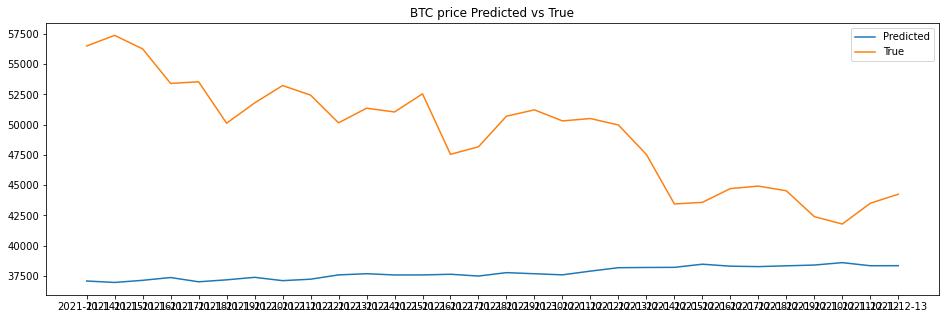

In [52]:
# Validation (validation with the last training days -> -15-15 DAYS)

# getting the predictions
y_pred = regressor.predict(X_train[-1].reshape(1, n_past, n_features)).tolist()[0]
#dummy = np.ones((len(y_pred),1))
#y_pred = np.array(y_pred).reshape(-1,1)
#y_pred = np.concatenate((y_pred, dummy), axis=1)
#y_pred = sc.inverse_transform(y_pred)#.tolist()
#y_pred = y_pred[:,0]
y_pred = dummy_invscaler(y_pred)
#y_pred = sc.inverse_transform(np.array(y_pred).reshape(-1,1))#.tolist()

# getting the true values
#y_true = y_train[-1].reshape(-1,1)
#y_true = np.concatenate((y_true, dummy), axis=1)
#y_true = sc.inverse_transform(y_true)
#y_true = y_true[:,0]
y_true = dummy_invscaler(y_train[-1])


print('y_pred:\n', y_pred.tolist())
print('y_true:\n', y_true.tolist())

# plotting the results
plt.figure(figsize=(16,5))
plt.plot(y_pred, label='Predicted')
plt.plot(y_true, label='True')

dates = df_train.index[-prediction_days:]
dates = [str(dates.date[i]) for i in range(len(dates))]
plt.xticks(range(prediction_days),dates)

plt.title('BTC price Predicted vs True')
plt.legend()
plt.show()

y_pred:
 [37091.46391063797, 36972.44308637968, 37148.15183838868, 37379.73122196847, 37026.24896970645, 37187.72948862369, 37395.32933610673, 37121.17444666842, 37240.90668258129, 37595.5966802104, 37692.788747792794, 37590.8980543987, 37592.4035999933, 37647.71833780608, 37501.04179908711, 37781.90381142705, 37690.65451282903, 37600.37802830751, 37907.26778053113, 38190.28388118334, 38209.68060266798, 38219.425287890124, 38479.037599552095, 38316.19381737118, 38280.709265818616, 38345.126763918706, 38409.83544446347, 38608.63033188671, 38352.39970725259, 38357.756802456206]
y_true:
 [41388.14895905966, 42995.310483289984, 43340.68766182639, 42082.02893086878, 41217.158638052446, 41788.32035689083, 41634.77613021395, 41783.36287549383, 43541.433860598554, 43045.84892569251, 44939.3894297034, 44944.76575352705, 44745.83981814187, 44908.059189479805, 44818.168111937994, 42181.44257440689, 40960.337931023954, 41672.35465483228, 40724.329875917916, 42039.991125253684, 41678.04823294517, 4

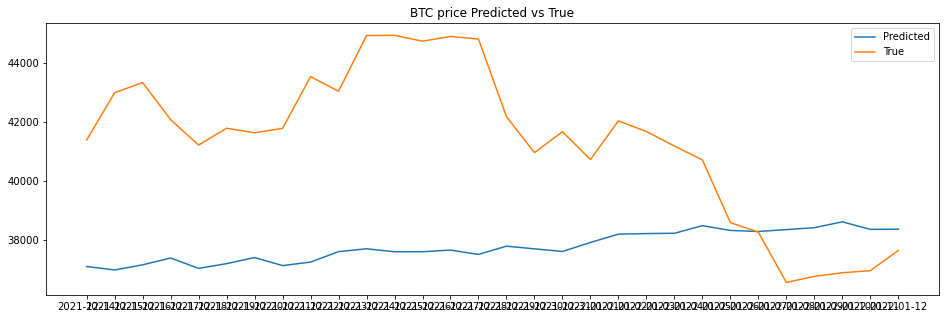

In [55]:
# Validation 2 (on the TEST SET -15 days)

# getting the predictions
x = df[['prices','total_volumes']][-n_past-prediction_days:-prediction_days].values
x = sc.transform(x)
y_pred = regressor.predict(x.reshape(1, n_past, n_features)).tolist()[0]
#y_pred = sc.inverse_transform(np.array(y_pred).reshape(-1,1))#.tolist()
y_pred = dummy_invscaler(y_pred)

# getting the true values
y_true = df['prices'][-prediction_days:].values

print('y_pred:\n', y_pred.tolist())
print('y_true:\n', y_true.tolist())

# plotting the results
plt.figure(figsize=(16,5))
plt.plot(y_pred, label='Predicted')
plt.plot(y_true, label='True')

dates = df.index[-prediction_days:]
dates = [str(dates.date[i]) for i in range(len(dates))]
plt.xticks(range(prediction_days),dates)

plt.title('BTC price Predicted vs True')
plt.legend()
plt.show()

In [56]:
# evaluation
rmse = math.sqrt(mean_squared_error(y_true, y_pred))

In [57]:
mean_absolute_error(y_true, y_pred)

4055.4122076796502

In [58]:
explained_variance_score(y_true, y_pred)
# Best possible score is 1.0, lower values are worse.

-0.297739236215367

y_pred:
 [37091.14294817055, 36972.18499284918, 37147.94668712084, 37379.532688483465, 37026.01072952445, 37187.428379504774, 37395.044771444904, 37121.11819551433, 37240.688295747794, 37595.2393199374, 37692.487638673876, 37590.64657865103, 37592.16866870271, 37647.46024427558, 37500.863118950605, 37781.668880136465, 37690.41296375561, 37600.19273038818, 37907.19829381138, 38190.04564100134, 38209.369566874804, 38219.29624112487, 38478.72656375893, 38316.19050847976, 38280.50411455078, 38344.948083782205, 38409.623675412804, 38608.497976230035, 38352.280587161586, 38357.62113790812]
y_true:
 [41388.14895905966, 42995.310483289984, 43340.68766182639, 42082.02893086878, 41217.158638052446, 41788.32035689083, 41634.77613021395, 41783.36287549383, 43541.433860598554, 43045.84892569251, 44939.3894297034, 44944.76575352705, 44745.83981814187, 44908.059189479805, 44818.168111937994, 42181.44257440689, 40960.337931023954, 41672.35465483228, 40724.329875917916, 42039.991125253684, 41678.048232

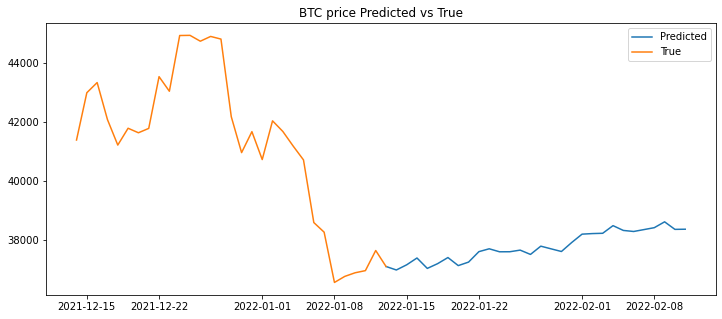

In [64]:
# Forecasting/Predicting

# getting the predictions
x = df[['prices','total_volumes']][-n_past:].values
x = sc.transform(x)
y_pred = regressor.predict(x.reshape(1, n_past, n_features)).tolist()[0]
#y_pred = sc.inverse_transform(np.array(y_pred).reshape(-1,1))#.tolist()
y_pred = dummy_invscaler(y_pred)

# creating a DF of the predicted prices
y_pred_df = pd.DataFrame(y_pred, 
                         index=pd.date_range(start=df[['prices']].index[-1]+dt.timedelta(days=1),
                                             periods=len(y_pred), 
                                             freq="D"), 
                         columns=df[['prices']].columns)

# getting the true values
y_true_df = df[['prices']].tail(prediction_days)

# linking them
y_true_df = y_true_df.append(y_pred_df.head(1))

print('y_pred:\n', y_pred.tolist())
print('y_true:\n', y_true.tolist())

# plotting the results
plt.figure(figsize=(12,5))
plt.plot(y_pred_df, label='Predicted')
plt.plot(y_true_df, label='True')

#dates = df.index[-prediction_days:]
#dates = [str(dates.date[i]) for i in range(len(dates))]
#plt.xticks(range(prediction_days),dates)

plt.title('BTC price Predicted vs True')
plt.legend()
plt.show()

In [ ]:
regressor.save('regressor.h5')
#loaded_regressor = load_model('regressor.h5')
#loaded_regressor.predict(new_x)